# Practical Session 6

- Fuzzy C-means
- EM algorithm OR Growing Regions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from scipy import ndimage
from scipy.interpolate import griddata
from scipy.spatial.distance import cdist
from skimage.color import rgb2gray
import matplotlib
import numpy.matlib 
import random 
from numpy import linalg

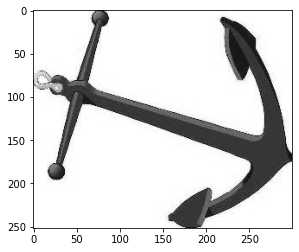

In [2]:
anchor = mpimg.imread('Images/anchor.jpg') 
anchor_gray = rgb2gray(anchor) 
plt.imshow(anchor_gray,cmap='gray')
plt.show() 

# Fuzzy C-means

**Implement Fuzzy C-means algorithm.**

**Test it on the different provided images.**

https://towardsdatascience.com/fuzzy-c-means-clustering-with-python-f4908c714081

In [3]:
def centroid(image, U, m): 
    # Input : image -- The gray image. 
    #         U -- The probability matrix. 
    #         m -- The algorithm coefficient. 
    # Output : result -- The central position of each cluster. 
    
    n_row, n_column, n_probability = np.shape(U) 
    L = [[0, 0] for _ in range(n_probability)] 
    for k in range(n_probability): 
        for y in range(n_row): 
            for x in range(n_column): 
                color = image[y][x] 
                probability = U[y][x][k] 
                L[k][0] += (probability**m) * color 
                L[k][1] += (probability**m) 
    
    return np.array([L[k][0] / L[k][1] for k in range(n_probability)]) 

#---------- ---------- ---------- ---------- ---------- ---------- ---------- 

def probability_matrix(image, C, m): 
    # Input : imgae -- The gray image. 
    #         C -- The centroid. 
    #         m -- The algorithm coefficient. It is 2 in default. 
    # Output : result -- The updated probability matrix. 
    
    n_row, n_column = np.shape(image) 
    n_probability = len(C) 
    res = [[[] for _ in range(n_column)] for _ in range(n_row)] 
    for y in range(n_row): 
        for x in range(n_column): 
            color = image[y][x] 
            for k in range(n_probability): 
                probability = 0 
                for n in range(n_probability): 
                    probability += (np.abs(color - C[k]) / np.abs(color - C[n]))**(2/(m-1)) 
                probability = 1 / probability 
                res[y][x].append(probability) 
    
    return res 

#---------- ---------- ---------- ---------- ---------- ---------- ---------- 

def fuzzy_c_means(image, c, m, N, tol): 
    # Input : image -- The gray image. 
    #         c -- The number of clusters. 
    #         m -- The algorithm coefficient. It is 2 in default. 
    #         N -- The maximum iteration. 
    #         tol -- The tolerence level. 
    # Output : result -- The final probability matrix. 
    
    n_row, n_column = np.shape(image) 
    
    # initialization of the centroid. 
    C = [random.random() for _ in range(c)] 
    
    # initialization of the probability matrix. 
    U = [[[] for _ in range(n_column)] for _ in range(n_row)] 
    for y in range(n_row): 
        for x in range(n_column): 
            for k in range(c): 
                U[y][x].append(random.random()) 
            U[y][x] = U[y][x] / np.sum(U[y][x]) 
    
    # iteratively updated the centroid and the probability matrix. 
    iteration = 0 
    while (iteration < N): 
        # print('Iteration = ', iteration) 
        iteration += 1 
        
        C_old = np.copy(C) 
        C = centroid(image, U, m) 
        epsilon = np.linalg.norm(C - C_old) 
        # print('Epsilon = ', epsilon) 
        
        U = probability_matrix(image, C, m) 
        if (epsilon < tol): 
            break 
        
    return U 

#---------- ---------- ---------- ---------- ---------- ---------- ---------- 

def test_fuzzy_c_means(image, c, m, N, tol): 
    # Input : image -- The gray image. 
    #         c -- The number of clusters. 
    #         m -- The algorithm coefficient. It is 2 in default. 
    #         N -- The maximum iteration. 
    #         tol -- The tolerence level. 
    # Output : res -- The resulting image. 
    
    cluster_color = np.arange(0, 1, 1/c) 
    U = fuzzy_c_means(image, c, m, N, tol) 
    n_row, n_column, n_probability = np.shape(U) 
    image_new = np.zeros([n_row, n_column]) 
    for i in range(n_row): 
        for j in range(n_column): 
            probability_list = list(U[i][j]) 
            cluster_index = probability_list.index(max(probability_list)) 
            image_new[i][j] = cluster_color[cluster_index] 
    
    return image_new 

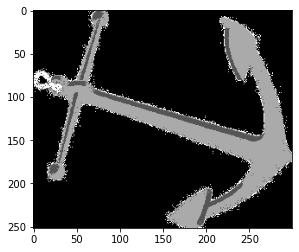

In [4]:
c = 4 
m = 2 
N = 30 
tol = 10e-4 

anchor_new = test_fuzzy_c_means(anchor_gray, c, m, N, tol) 
plt.imshow(anchor_new, cmap='gray') 

# EM algorithm to estimate a gaussian mixture

**Implement here EM algorithm to estimate a gaussian mixture.**

**Test it on the different provided images.**

https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

In [18]:
def gaussian(x, mu, sigma): 
    # Input : x -- A data point. 
    #         mu -- The mean value. 
    #         sigma -- The standard deviation. 
    # Output : res -- The gaussian probability of x. 
    
    return np.exp(-(1/2) * (((x-mu)/sigma)**2)) / (sigma * np.sqrt(2*np.pi)) 

#---------- ---------- ---------- ---------- ---------- ---------- ---------- 

def expectation_step(image, c, pi, cluster_mean, cluster_deviation): 
    # Input : image -- The gray image. 
    #         c -- The number of clusters. 
    #         pi
    #         cluster_mean 
    #         cluster_deviation 
    # Output : res -- The probability matrix. 
    
    n_row, n_column = np.shape(image) 
    
    # the probability matrix. 
    gamma = np.zeros((n_row, n_column, c)) 
    for i in range(n_row): 
        for j in range(n_column): 
            x = image[i][j] 
            coefficient_2 = np.sum([pi[n] * gaussian(x, cluster_mean[n], np.sqrt(cluster_deviation[n])) for n in range(c)]) 
            for k in range(c): 
                coefficient_1 = pi[k] * gaussian(x, cluster_mean[k], np.sqrt(cluster_deviation[k])) 
                gamma[i][j][k] = coefficient_1 / coefficient_2 
    
    return gamma 

#---------- ---------- ---------- ---------- ---------- ---------- ---------- 

def maximization_step(image, c, cluster_mean, gamma): 
    # Input : image -- The gray image. 
    #         c -- The number of clusters. 
    #         cluster_mean 
    #         gamma -- The probability matrix. 
    # Output : pi_new, cluster_mean_new, cluster_deviation_new 
    
    n_row, n_column = np.shape(image) 
    n_total = n_row * n_column 
    
    # useful summation that is needed to compute the maximized values. 
    N = np.zeros(3) 
    for k in range(c): 
        N[k] = np.sum([gamma[i][j][k] for i in range(n_row) for j in range(n_column)]) 
    
    # maximization of pi. 
    pi_new = np.zeros(3) 
    for k in range(c): 
        pi_new[k] = N[k] / n_total 
    
    # maximization of cluster_mean. 
    cluster_mean_new = np.zeros(3) 
    for k in range(c): 
        cluster_mean_new[k] = np.sum([gamma[i][j][k] * image[i][j] for i in range(n_row) for j in range(n_column)]) / N[k] 
    
    # maximization of cluster_deviation. 
    cluster_deviation_new = np.zeros(3) 
    for k in range(c): 
        cluster_deviation_new[k] = np.sum([gamma[i][j][k] * (image[i][j] - cluster_mean[k])**2 for i in range(n_row) for j in range(n_column)]) / N[k] 
    
    return pi_new, cluster_mean_new, cluster_deviation_new 

#---------- ---------- ---------- ---------- ---------- ---------- ---------- 

def log_likelihood(image, c, pi, cluster_mean, cluster_deviation): 
    # Input : image -- The gray image. 
    #         c -- The number of clusters. 
    #         pi
    #         cluster_mean 
    #         cluster_deviation 
    # Output : res -- The log_likelihood  
    
    n_row, n_column = np.shape(image) 
    
    # the log-likelihood. 
    res = 0 
    for i in range(n_row): 
        for j in range(n_column): 
            res += np.log(np.sum([pi[k] * gaussian(image[i][j], cluster_mean[k], np.sqrt(cluster_deviation[k]))  for k in range(c)]))
    
    return res 

#---------- ---------- ---------- ---------- ---------- ---------- ---------- 

def EM_Gaussian_Mixture(image, c, N, tol): 
    # Input : image -- The gray image. 
    #         c -- The number of clusters. 
    #         N -- The maximum iteration. 
    #         tol -- The tolerence. 
    # Output : gamma, likelihood_list 
    
    n_row, n_column = np.shape(image) 
    n_total = n_row * n_column 
    
    # initialization. 
    pi = np.array([1/c for _ in range(c)]) 
    cluster_mean = np.array([random.choice(image.flatten()) for _ in range(c)]) 
    data_mean = (1 / n_total) * np.sum(image)  
    data_deviation = (1 / n_total) * np.sum([np.abs(image[i][j] - data_mean)**2 for i in range(n_row) for j in range(n_column)]) 
    cluster_deviation = np.array([data_deviation for _ in range(c)]) 
    
    # iteratively update the log-likelihood. 
    likelihood_list = [] 
    iteration = 0 
    while (iteration < N): 
        iteration += 1 
        
        gamma = expectation_step(image, c, pi, cluster_mean, cluster_deviation) 
        pi_new, cluster_mean_new, cluster_deviation_new = maximization_step(image, c, cluster_mean, gamma) 
        
        likelihood_old = log_likelihood(image, c, pi, cluster_mean, cluster_deviation) 
        likelihood = log_likelihood(image, c, pi_new, cluster_mean_new, cluster_deviation_new) 
        likelihood_list.append(likelihood) 
        
        epsilon = np.abs(likelihood - likelihood_old) 
        if (epsilon < tol): 
            break 
        
        pi, cluster_mean, cluster_deviation = pi_new, cluster_mean_new, cluster_deviation_new 
    
    return gamma, likelihood_list 

#---------- ---------- ---------- ---------- ---------- ---------- ---------- 

def test_EM_Gaussian_Mixture(image, c, N, tol): 
    # Input : image -- The gray image. 
    #         c -- The number of clusters. 
    #         m -- The algorithm coefficient. It is 2 in default. 
    #         N -- The maximum iteration. 
    #         tol -- The tolerence level. 
    # Output : image_new, likelihood 
    
    cluster_color = np.arange(0, 1, 1/c) 
    gamma, likelihood_list = EM_Gaussian_Mixture(image, c, N, tol) 
    n_row, n_column, n_probability = np.shape(gamma) 
    image_new = np.zeros([n_row, n_column]) 
    for i in range(n_row): 
        for j in range(n_column): 
            probability_list = list(gamma[i][j]) 
            cluster_index = probability_list.index(max(probability_list)) 
            image_new[i][j] = cluster_color[cluster_index] 
    
    return image_new, likelihood_list 

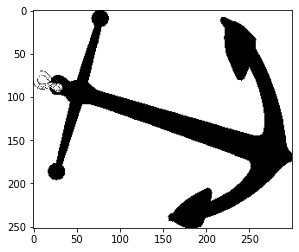

In [21]:
c = 3
N = 6
tol = 1e-4  

anchor_new, likelihood_list = test_EM_Gaussian_Mixture(anchor_gray, c, N, tol) 
plt.imshow(anchor_new, cmap='gray') 
plt.show() 

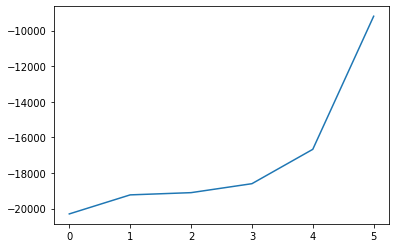

In [22]:
plt.plot(np.arange(0, N, 1), likelihood_list) 
plt.show() 

# Growing Region

**Implement here growing region method to segment a gray image and test it.**

We provide you code to select your own seeds/markers on the original image.
In this code, you can change `n_regions` the number of different regions you want in your image, so it fixes the size of your markers array. \
It returns you object named `seeds`, a numpy array of size _(n_regions,2)_ with the first column corresponding to y-axis (rows of your image) and 2nd column is x-axis (columns of your image).

**Be careful : it should open you a plot window outside of the notebook in order to select the points. After you pressed Enter key, it may not close the window but you do not care, just switch back to your notebook window. You can then print your seeds to be sure they are stored.**

In [ ]:
matplotlib.use( 'tkagg' )

n_regions = 2


def tellme(s):
    print(s)
    plt.title(s, fontsize=16)
    plt.draw()

plt.clf()
plt.imshow(I_gray,cmap='gray')

tellme('You will define markers, click to begin')
plt.waitforbuttonpress()



while True:

    seeds = None    
    for lab in range(1,n_regions+1):
        pts = []
         
        tellme('Select markers for label %d' % lab)
        pts = np.asarray(plt.ginput(1, timeout=-1))


        if seeds is None :
            seeds = np.rint(pts).copy()
        else :
            seeds = np.append(seeds, np.rint(pts), axis=0)

   
    seeds = seeds.astype(int)

    tellme('Happy? Press Enter on keyboard for yes, mouse click for no')
    if plt.waitforbuttonpress():
        break
